In [ ]:
# !cp /kaggle/input/data-bowl-2019-external-data/*.py /kaggle/working

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
import jupytools.syspath
def ignore(*args, **kwargs): pass
warnings.warn = ignore
jupytools.syspath.add('..')

In [2]:
from functools import partial

import numpy as np
import pandas as pd
from IPython.display import display

import bundle
import features as F
import selection
import utils as U
from dataset import load, load_sample, Subset
from encode import encode
from training import train, inference, submit
from meta import compute_meta_data
from metric import optimize_rounding_bounds, RegressionCappa

In [3]:
sample = False
if U.on_kaggle():
    U.log('Loading test set only.')
    tst_data = pd.read_csv('/kaggle/input/data-science-bowl-2019/test.csv')
else:
    if sample:
        U.log('Warning: loading train and test data sample.')
        trn_data, _, _ = load_sample(Subset.Train, 500_000)
        [tst_data] = load_sample(Subset.Test, 500_000)
    else:
        U.log('Loading train and test.')
        trn_data, trn_spec, trn_targ = load(Subset.Train)
        [tst_data] = load(Subset.Test)

Loading train and test.
(11341042, 11) (17690, 7) (386, 3) (1156414, 11) 

## Preparing

In [4]:
transform = U.combine(
    partial(F.add_feature_combinations, pairs=[('title', 'event_code')]),
    partial(F.add_datetime, column='timestamp', prefix='ts'),
    partial(F.add_cyclical, prefix='ts')
)

if U.on_kaggle():
    U.log('Transforming test data only.')
    X_tst = transform(tst_data.copy())
    U.log(X_tst.shape)
else:
    U.log('Transforming train and test data.')
    X_tst = transform(tst_data.copy())
    X_trn = transform(trn_data.copy())
    U.log(X_trn.shape, X_tst.shape)

Transforming train and test data.
(11341042, 31) (1156414, 31)


In [5]:
if U.on_kaggle():
    U.log('Reading pre-computed meta from disk.')
    meta = bundle.meta()
else:
    U.log('Computing meta using train and test datasets.')
    meta = compute_meta_data(X_trn, X_tst)
    U.log('Saving computed meta on disk.')
    bundle.save_meta(meta, 'meta')

Computing meta using train and test datasets.
Saving computed meta on disk.


In [6]:
extractor = F.FeaturesExtractor([
    F.CountingFeatures(meta),
    F.PerformanceFeatures(meta),
    # F.CyclicFeatures(meta),
    # F.TimestampFeatures(meta),
    F.VarietyFeatures(meta),
    F.EventDataFeatures(meta)
])

algo = F.InMemoryAlgorithm(extractor, meta, num_workers=12)

cat_cols = ['session_title']

if U.on_kaggle():
    U.log('Preparing test dataset.')
    X_tst = algo.run(X_tst, test=True)
    encoders = bundle.encoders()
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
else:
    U.log('Preparing train and test datasets.')
    X_trn = algo.run(X_trn)
    X_tst = algo.run(X_tst, test=True)
    X_trn, encoders = encode(X_trn, cat_cols)
    X_tst, _ = encode(X_tst, cat_cols, encoders=encoders)
    bundle.save(encoders, 'encoders')

Preparing train and test datasets.
Running algorithm in train mode.



Running algorithm in test mode.


In [9]:
if U.on_kaggle():
    U.log('Running post-processing on test set only.')
    F.add_user_wise_features(X_tst, meta)
else:
    U.log('Running post-processing on train and test sets.')
    F.add_user_wise_features(X_trn, meta)
    F.add_user_wise_features(X_tst, meta)

Running post-processing on train and test sets.


## Experiments

In [8]:
def match_cols(cols, regex):
    import re
    return [col for col in cols if re.match(regex, col)]
def starts_with(cols, prefix): 
    return match_cols(cols, f'^{prefix}')

In [16]:
from collections import OrderedDict

columns = X_trn.columns.tolist()
cnt_cols = starts_with(columns, 'cnt_')
perf_cols = starts_with(columns, 'perf_')
var_cols = starts_with(columns, 'var_')
user_cols = starts_with(columns, 'user_')
ts_cols = starts_with(columns, 'ts_')
event_cols = starts_with(columns, 'event_')
cols = cnt_cols + perf_cols + var_cols + ts_cols

features_groups = [
#     ('all', cols),
#     ('cnt', cnt_cols),
#     ('perf', perf_cols),
#     ('var', var_cols),
#     ('user', user_cols),
#     ('ts', ts_cols),
#     ('cnt+perf', cnt_cols + perf_cols),
#     ('cnt+var', cnt_cols + var_cols),
#     ('cnt+ts', cnt_cols + ts_cols),
#     ('perf+var', perf_cols + var_cols),
#     ('perf+ts', perf_cols + ts_cols),
#     ('cnt+user', cnt_cols + user_cols),
#     ('cnt+perf+var', cnt_cols + perf_cols + var_cols),
#     ('cnt+perf+user', cnt_cols + perf_cols + user_cols),
#     ('cnt+perf+user+var', cnt_cols + perf_cols + user_cols + var_cols),
    ('event', event_cols),
    ('event+cnt', event_cols + cnt_cols),
    ('event+cnt+perf', event_cols + cnt_cols + perf_cols),
    ('event+cnt+perf+user', event_cols + cnt_cols + perf_cols + user_cols)
]

In [18]:
results = []
for col_group, features in features_groups:
    U.log(f'Training columns group: {col_group}')
    reg_metric = RegressionCappa([-np.inf, 1., 2., 3., +np.inf])
    result = train(X_trn, features, reg_metric, algo='lightgbm')
    results.append((col_group, result))

Training columns group: event
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.19533	trn's cappa: 0.149311	val's rmse: 1.22293	val's cappa: 0.117832
[200]	trn's rmse: 1.16354	trn's cappa: 0.180835	val's rmse: 1.21065	val's cappa: 0.131162
[300]	trn's rmse: 1.14107	trn's cappa: 0.208489	val's rmse: 1.20641	val's cappa: 0.136011
[400]	trn's rmse: 1.12249	trn's cappa: 0.238584	val's rmse: 1.2042	val's cappa: 0.141848
[500]	trn's rmse: 1.10644	trn's cappa: 0.261365	val's rmse: 1.20304	val's cappa: 0.141015
Early stopping, best iteration is:
[432]	trn's rmse: 1.11711	trn's cappa: 0.245906	val's rmse: 1.20366	val's cappa: 0.145553
Running k-fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.19175	trn's cappa: 0.147837	val's rmse: 1.22471	val's cappa: 0.136004
[200]	trn's rmse: 1.1613	trn's cappa: 0.186583	val's rmse: 1.2125	val's cappa: 0.152465
[300]	trn's rmse: 1.1398	trn's cappa: 0.217244	v

[800]	trn's rmse: 0.940698	trn's cappa: 0.469935	val's rmse: 1.13631	val's cappa: 0.265195
Early stopping, best iteration is:
[741]	trn's rmse: 0.950162	trn's cappa: 0.461694	val's rmse: 1.13604	val's cappa: 0.265387
Training columns group: event+cnt+perf
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.1397	trn's cappa: 0.237411	val's rmse: 1.17383	val's cappa: 0.215033
[200]	trn's rmse: 1.08584	trn's cappa: 0.304468	val's rmse: 1.14351	val's cappa: 0.237892
[300]	trn's rmse: 1.05017	trn's cappa: 0.352138	val's rmse: 1.13059	val's cappa: 0.253236
[400]	trn's rmse: 1.02277	trn's cappa: 0.382756	val's rmse: 1.1237	val's cappa: 0.268961
[500]	trn's rmse: 1.00033	trn's cappa: 0.407378	val's rmse: 1.1196	val's cappa: 0.277137
[600]	trn's rmse: 0.980614	trn's cappa: 0.429827	val's rmse: 1.11795	val's cappa: 0.284045
[700]	trn's rmse: 0.962866	trn's cappa: 0.446872	val's rmse: 1.11728	val's cappa: 0.288277
Early stopping, best iteration

Early stopping, best iteration is:
[682]	trn's rmse: 0.953452	trn's cappa: 0.456345	val's rmse: 1.10726	val's cappa: 0.322497
Running k-fold 5 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.12982	trn's cappa: 0.26118	val's rmse: 1.18274	val's cappa: 0.193495
[200]	trn's rmse: 1.07475	trn's cappa: 0.317657	val's rmse: 1.15433	val's cappa: 0.229783
[300]	trn's rmse: 1.03742	trn's cappa: 0.368204	val's rmse: 1.14054	val's cappa: 0.252243
[400]	trn's rmse: 1.00868	trn's cappa: 0.400499	val's rmse: 1.13302	val's cappa: 0.266021
[500]	trn's rmse: 0.98496	trn's cappa: 0.428196	val's rmse: 1.12864	val's cappa: 0.278136
[600]	trn's rmse: 0.964105	trn's cappa: 0.448174	val's rmse: 1.12617	val's cappa: 0.281081
[700]	trn's rmse: 0.946	trn's cappa: 0.465769	val's rmse: 1.12433	val's cappa: 0.285572
[800]	trn's rmse: 0.928579	trn's cappa: 0.484735	val's rmse: 1.12328	val's cappa: 0.286997
[900]	trn's rmse: 0.913	trn's cappa: 0.498758	val's rmse: 1.12262	val'

In [24]:
report = pd.DataFrame([
    OrderedDict([('features', name)] + list(result.cv.items())) 
    for name, result in results])
cappa_cols = starts_with(report.columns, 'cv_cappa')
report['mean'] = report[cappa_cols].mean(axis=1)
report['std'] = report[cappa_cols].std(axis=1)
report.sort_values(by=['mean'], inplace=True, ascending=False)
report.reset_index(drop=True, inplace=True)

In [20]:
report.to_csv(f'report_events_{U.now()}.csv', index=False)

In [25]:
report

,features,cv_cappa_1,cv_cappa_2,cv_cappa_3,cv_cappa_4,cv_cappa_5,mean,std
0,event+cnt+perf+user,0.304276,0.307495,0.306187,0.322497,0.291188,0.306329,0.011138
1,event+cnt+perf,0.288480,0.298608,0.288956,0.305702,0.262454,0.288840,0.016402
2,event+cnt,0.278725,0.281626,0.276371,0.308342,0.265387,0.282090,0.015909
3,event,0.145553,0.162732,0.119935,0.170449,0.152481,0.150230,0.019428


In [33]:
benchmark = pd.concat([
    pd.read_csv('report_Tue_07_Jan_2020__16_48.csv'),
    report
], axis=0).reset_index(drop=True).sort_values(by=['mean'], ascending=False).reset_index(drop=True)

In [34]:
def highlight_best(col):
    if not col.name.startswith('cv_cappa_'):
        return [''] * len(col)
    is_best = col.index == col.argmax()
    return ['background-color: salmon' if idx else '' for idx in is_best]

In [35]:
benchmark.style.apply(highlight_best)

,features,cv_cappa_1,cv_cappa_2,cv_cappa_3,cv_cappa_4,cv_cappa_5,mean,std
0,event+cnt+perf+user,0.304276,0.307495,0.306187,0.322497,0.291188,0.306329,0.0111385
1,event+cnt+perf,0.28848,0.298608,0.288956,0.305702,0.262454,0.28884,0.0164019
2,event+cnt,0.278725,0.281626,0.276371,0.308342,0.265387,0.28209,0.0159092
3,cnt+perf+user,0.280617,0.263356,0.279415,0.302204,0.257902,0.276699,0.0173536
4,cnt+perf+user+var,0.275224,0.271732,0.281025,0.29761,0.24994,0.275106,0.0172206
5,cnt+user,0.267638,0.263846,0.280823,0.287238,0.270695,0.274048,0.00969909
6,cnt+perf+var,0.268211,0.264924,0.272204,0.293188,0.239004,0.267506,0.0193723
7,cnt+perf,0.262715,0.263792,0.269123,0.291618,0.243184,0.266086,0.0173367
8,cnt+var,0.25767,0.253572,0.269927,0.287883,0.249354,0.263681,0.0155589
9,all,0.260508,0.252813,0.263456,0.296266,0.244317,0.263472,0.0197784


In [204]:
report['cv_cappa_1'].index == report['cv_cappa_1'].argmax()

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [193]:
for cappa_col in starts_with(report.columns, 'cv_cappa_'):
    report[cappa_col].argmax

['cv_cappa_1', 'cv_cappa_2', 'cv_cappa_3', 'cv_cappa_4', 'cv_cappa_5']

In [151]:
import json
sample = trn_data.sample(1_000_000)
event_data = pd.io.json.json_normalize(sample.event_data.apply(json.loads))

In [153]:
from dataset import existing_info
stat_info = existing_info(event_data).T.reset_index()

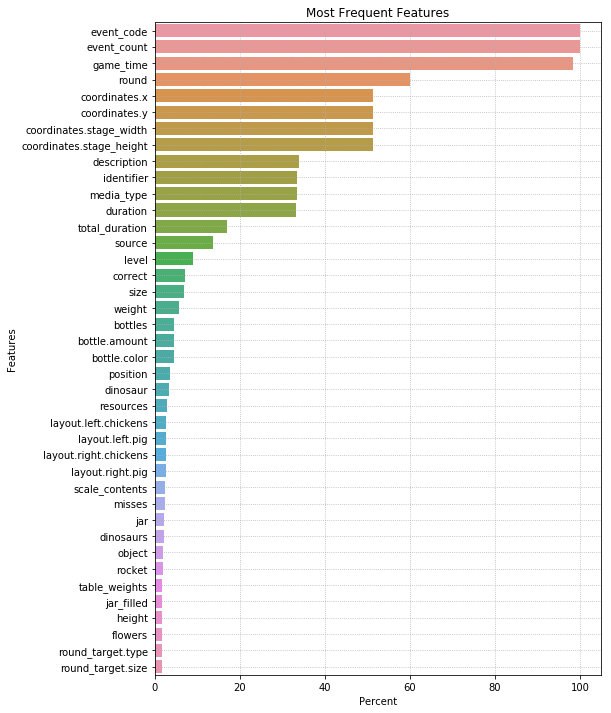

In [157]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(8, 12))
ax = sns.barplot(x='Percent', y='index', data=stat_info.head(40))
ax.set_title('Most Frequent Features')
ax.set_ylabel('Features')
ax.grid(True, linestyle='dotted')

In [171]:
freq_keys = stat_info['index'][stat_info['Percent'] >= 5.].tolist()

In [172]:
freq_keys

['event_code',
 'event_count',
 'game_time',
 'round',
 'coordinates.x',
 'coordinates.y',
 'coordinates.stage_width',
 'coordinates.stage_height',
 'description',
 'identifier',
 'media_type',
 'duration',
 'total_duration',
 'source',
 'level',
 'correct',
 'size',
 'weight']

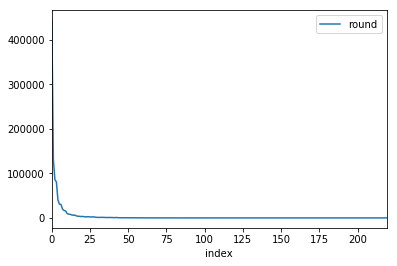

In [246]:
round_df = event_data['round'].fillna(0).value_counts().reset_index()
round_df['index'] = round_df['index'].astype(int)
round_df.sort_values(by='index', inplace=True)
round_df.plot(x='index', y='round')

In [251]:
np.isnan(event_data['coordinates.x'].iloc[3])

True

In [248]:
event_data['coordinates.x'].fillna(0)

0         954.0
1         393.0
2           0.0
3           0.0
4           0.0
          ...  
999995    910.0
999996    752.0
999997    646.0
999998      0.0
999999    337.0
Name: coordinates.x, Length: 1000000, dtype: float64

In [266]:
event_data['media_type'].fillna('unknown').value_counts()

unknown      665828
animation    222336
audio        111836
Name: media_type, dtype: int64

In [234]:
# round: float with NaNs
# coordinates.(x|y): float with NaNs, but presumably integer
# coordinates.stage_(width|height): float with NaNs, but presumably categorical
#
# description: text messages, try to convert into categoricals?
#     (event_data['description'].fillna('n/a').value_counts()
#      .rename('count').reset_index().rename(columns={'index': 'text'}))
#
# identifier: some string, probably concatenated with commas; most simple is to compute len
# event_data['identifier'].fillna('n/a').str.split(',').apply(len)
#
# media_type: categorical string
# event_data['media_type'].fillna('n/a').value_counts()
#
# duration: should already exist in the features set
# total_duration: probably also present in the features
#
# source: also some kind of categorical string
# event_data['source'].fillna('n/a').value_counts()
#
# level: integer feature, can be used as a cumulative metric (?)
# event_data['level'].fillna('n/a').value_counts()
#
# correct: defines if attempt was done, is already used in feature processing
# 
# size: integer feature
# event_data['size'].fillna('n/a').value_counts()
#
# weight: one more integer feature
# event_data['weight'].fillna('n/a').value_counts()

## Features Selection

In [10]:
selector = selection.FeatureSelection(
    rules=[
        ('nonzero', selection.non_zero_rows_and_cols),
        ('uncorr', selection.non_correlated_cols),
    ],
    ignore_cols=[
        'accuracy_group', 
        'installation_id', 
        'game_session'
    ]
)

if U.on_kaggle():
    U.log('Loading relevant features list from disk.')
    features = bundle.features()
else:
    U.log('Deriving relevant features from train dataset.')
    features = selector.select(X_trn)
    bundle.save(features, 'features')

Deriving relevant features from train dataset.
Excluding from consideration: ['accuracy_group', 'installation_id', 'game_session']
Applying feature selection rule: nonzero
Selected features: 935 of 950
Applying feature selection rule: uncorr


/home/ck/anaconda3/envs/fastai_10/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ck/anaconda3/envs/fastai_10/lib/python3.7/site-packages/numpy/lib/function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]



Selected features: 441 of 950
Keeping only features, selected by every rule.
Final number of features changed from 950 to 429


## Submission

In [12]:
algo = 'lightgbm'
version = '012'

if U.on_kaggle():
    U.log('Inference on Kaggle.')
    predicted = inference(X_tst, features, bounds=bounds, model=algo, version=version)
    U.log('Saving predictions on disk.')
    filename = submit(predicted)
    submit_df = pd.read_csv(filename)
    U.log('First 20 submission rows:')
    display(submit_df.head(20))
    
else:
    U.log('Training with sub-optimal rounding.')
    reg_metric = RegressionCappa([-np.inf, 1., 2., 3., +np.inf])
    result = train(X_trn, features, reg_metric, algo=algo)
    
    U.log('Using predictions to find optimal rounding boundaries.')
    opt_bounds = optimize_rounding_bounds(result.oof, X_trn['accuracy_group'].values)
    U.log(f'Optimal values: {opt_bounds}')
    
    U.log('Using optimal boundaries to train a new ensemble of models.')
    reg_metric = RegressionCappa(opt_bounds)
    result = train(X_trn, features, reg_metric, algo=algo)
    
    U.log('Saving the final results.')
    bundle.save(result.models, f'models_{algo}_{version}')
    bundle.save(opt_bounds, 'bounds')

Training with sub-optimal rounding.
Running k-fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	trn's rmse: 1.03695	trn's cappa: 0.377313	val's rmse: 1.05461	val's cappa: 0.34896
[200]	trn's rmse: 0.964831	trn's cappa: 0.486422	val's rmse: 0.999919	val's cappa: 0.453698
[300]	trn's rmse: 0.929411	trn's cappa: 0.514166	val's rmse: 0.983294	val's cappa: 0.471362
[400]	trn's rmse: 0.903972	trn's cappa: 0.530141	val's rmse: 0.975349	val's cappa: 0.472125
[500]	trn's rmse: 0.883368	trn's cappa: 0.545427	val's rmse: 0.971314	val's cappa: 0.474345
[600]	trn's rmse: 0.865445	trn's cappa: 0.556055	val's rmse: 0.969125	val's cappa: 0.474981
[700]	trn's rmse: 0.849136	trn's cappa: 0.565808	val's rmse: 0.968358	val's cappa: 0.477246
[800]	trn's rmse: 0.83407	trn's cappa: 0.575531	val's rmse: 0.967616	val's cappa: 0.479028
[900]	trn's rmse: 0.820082	trn's cappa: 0.586228	val's rmse: 0.967105	val's cappa: 0.480056
[1000]	trn's rmse: 0.806759	trn's cappa: 0.596583	val's

In [13]:
if not U.on_kaggle():
    import os
    features = bundle.features()
    bounds = bundle.bounds()
    filename = submit(inference(X_tst, features, bounds, model=algo, version=version))
    assert os.path.exists(filename)
    assert pd.read_csv(filename).shape[0] == 1000
    bundle.package(folder='/home/ck/data/bowl2019/external/')

Running inference on dataset of shape: 429
Loading external models: lightgbm v012.
Running models on test data...
Averaging ensemble predictions.
Rounding predictions using optimal bounds.
Converting predictions into submission file.
Running locally.
(1000, 2) Packaging training results into dataset.
/tmp/bowl2019/meta.joblib --> /home/ck/data/bowl2019/external/meta.joblib
/tmp/bowl2019/models_lightgbm_012.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_012.joblib
/tmp/bowl2019/bounds.joblib --> /home/ck/data/bowl2019/external/bounds.joblib
/tmp/bowl2019/models_lightgbm_010.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_010.joblib
/tmp/bowl2019/features.joblib --> /home/ck/data/bowl2019/external/features.joblib
/tmp/bowl2019/encoders.joblib --> /home/ck/data/bowl2019/external/encoders.joblib
/tmp/bowl2019/models_lightgbm_011.joblib --> /home/ck/data/bowl2019/external/models_lightgbm_011.joblib
/tmp/bowl2019/models_lightgbm_008.joblib --> /home/ck/data/bowl2019/ex